<a href="https://colab.research.google.com/github/abckev/MetodiNumerici/blob/main/Progetto_MetodiNumerici.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.integrate

Compile the following notebook and share a link with me sending and e-mail to giovanni.stabile@uniurb.it at least one week before the oral examination. All the implemented function will have to be properly documented and commented.

Compile The following Cell with your information. In case it is a group project, put the info for all the group members

Name1: Kevin

Surname1: Berberolli

Email1: k.berberolli@campus.uniurb.it

Consider the following one-dimensional PDE:
$$
-u_{xx}(x) = f(x)\quad\mathrm{ in }\ \Omega = (0, \pi)
$$
$$
u(x) = 0, \quad\mathrm{ on }\ \partial\Omega = \{0, \pi\}
$$

Given the following $4^{th}$ order finite difference approximation of the second order derivative:

$$u_{xx}(x_i) = \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2}$$

Implement a function that given the domain interval, the forcing function, the number of discretization points, the boundary conditions, returns the matrix $A$ and the the right hand side $b$.


## Considerazioni iniziali
As seen in the classroom exercises, for the numerical discretization of the problem, we consider a *Finite Difference (FD) Approximation*.

In order to formulate the discrete problem, we consider a FD approximation of the left-hand side, as follows ($4^{th}$ order finite difference approximation of the second order derivative):

$$u_{xx}(x_i) \approx \frac{-u_{i-2}+16u_{i-1}-30u_i+16u_{i+1}-u_{i+2}}{12h^2} \qquad \text{for} \qquad  i = 2, ..., n-2$$

while we use the $2^{th}$ order finite difference approximation of the second order derivative for the remaining points $(i = 1, n-1)$:

$$
-u_{xx}(x_i) \approx \frac{-u_{i-1} + 2u_i - u_{i+1}}{h^2} \qquad \text{for} \qquad  i = 1, n-1
$$

being $h = \frac{\pi}{n-1}$ the size of each subinterval $(x_i, x_{i+1})$.

In [ ]:
#La funzione genera il sistema lineare di equazioni (Ax = b) implementando lo schema alle differenze finite del 4° ordine
# per una PDE generale nella forma: -u_xx(x) = f(x) con condizioni di contorno u(x_0) = bc[0] and u(x_n) = bc[1]
def finDif(omega, f, n, bc):

    h = np.abs(omega[0] - omega[1]) / (n - 1)

    x = np.linspace(omega[0], omega[1], n)

    # termine di approssimazione del 4° ordine
    termine_noto = -f(x)

    # termine di approssimazione del 2° ordine
    termine_noto[1] = f(x[1])
    termine_noto[-2] = f(x[-2])

    # Conzdizioni di contorno
    termine_noto[0] = bc[0]
    termine_noto[-1] = bc[1]

    # Discretizzazione della matrice
    A = np.zeros((n, n))

    a = -np.ones((n-2, ))
    b = 16*np.ones((n-1, ))
    c = -30*np.ones((n, ))
    A = (np.diag(a, -2) + np.diag(a, +2) + np.diag(b, -1) + np.diag(b, +1) + np.diag(c, 0))
    A /= (12*h**2)

    # Cambio la prima riga della matrice
    A[0, :] = np.zeros(n)
    A[1, :] = np.zeros(n)

    A[n-1, :] = np.zeros(n)
    A[n-2, :] = np.zeros(n)

    # 2° ordine
    A_second_row = np.array([-1.0, 2.0, -1.0]) / (h**2)
    A_second_last_row = np.array([-1.0, 2.0, -1.0]) / (h**2)

    A[1, 0:3] = A_second_row
    A[n-2, n-3:n] = A_second_last_row

    A[0, 0] = 1
    A[-1, -1] = 1

    return A, termine_noto

Call the function using:

In [ ]:
# Parametri
omega = [0, np.pi]
f = lambda x : np.sin(x)
n = 100
bc = [0, 0]
A, b = finDif(omega, f, n, bc)


Implement two functions that compute the LU and the Cholesky factorization of the system matrix $A$

## LU decomposition

We want to implement our linear solver using an **LU decomposition** (without pivoting)
$$
A = LU
$$

In [ ]:
# La funzione impementa la fattorizzazione LU della matrice A
def LU(A):
    A = A.copy()  #copia della matrice
    N = len(A)
    for k in range(N-1):
        if (abs(A[k,k]) < 1e-15):
            raise RuntimeError("Null pivot")

        A[k+1:N,k] /= A[k,k]

        for j in range(k+1,N):
            A[k+1:N,j] -= A[k+1:N,k]*A[k,j]

    L = np.tril(A)    # L matrice triangolare inferiore

    for i in range(N):
        L[i,i] = 1.0

    U = np.triu(A)   # U matrice triangolare superiore

    return L, U

#L, U = LU(A)

## Cholesky decomposition

The Cholesky decomposotion seeks an upper triangular matrix $H$ (with all positive elements on the diagonal) such that
$$
A = H^T H
$$

In [ ]:
# La funzione implementa la fattorizzazione di Cholesky
def cholesky(A):
    A = A.copy()
    N = len(A)
    for k in range(N-1):
        A[k,k] = np.sqrt(A[k,k])
        A[k+1:N,k] = A[k+1:N,k]/A[k,k]

        for j in range(k+1,N):
            A[j:N,j] = A[j:N,j] - A[j:N,k]*A[j,k]

    A[-1,-1] = np.sqrt(A[-1,-1])
    L = np.tril(A)

    return L, L.transpose()

#HT, H = cholesky(A)

Implement forward and backward substitution functions to exploit the developed factorization methods to solve the derived linear system of equations.

In [ ]:
# La funzione implementa la sostituzione all'avanti per risolvere il sistema lineare nella forma Lx = rhs
def L_solve(L, rhs):
    x = np.zeros_like(rhs)
    N = len(L)

    x[0] = rhs[0]/L[0,0]

    for i in range(1,N):
        x[i] = (rhs[i] - np.dot(L[i, 0:i], x[0:i]))/L[i,i]

    return x

In [ ]:
# La funzione implementa la sostituzione all'indietro per risolvere il sistema lineare nella forma Ux = rhs
def U_solve(U, rhs):
    x = np.zeros_like(rhs)
    N = len(U)

    x[-1] = rhs[-1]/U[-1,-1]

    for i in reversed(range(N-1)):
        x[i] = (rhs[i] -np.dot(U[i, i+1:N], x[i+1:N]))/U[i,i]

    return x

Solve the derived linear system using the implemented functions and plot the computed solution:

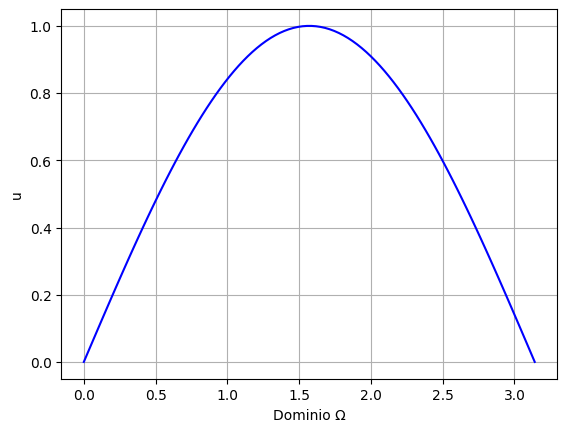

In [ ]:
#TODO
A, b = finDif(omega, f, n, bc)
L, U = LU(A)
w = L_solve(L, b)
u = U_solve(U, w)

x = np.linspace(omega[0], omega[1], n)
plt.plot(x, u, '-b')
plt.xlabel('Dominio Ω')
plt.ylabel('u')
plt.grid()

Considering the new domain $\Omega = (0,1)$ and the forcing term $f(x) = x(1-x)$ with B.C. $u(x) = 0$, on $\partial \Omega = {0,1}$ produce a plot and a table where you show the decay of the error w.r.t. the number of grid points.
(The analytical solution for the above problems is $u_{an} = \frac{x^4}{12} - \frac{x^3}{6} + \frac{x}{12}$)

Errore: 2.3176179749389897e-07


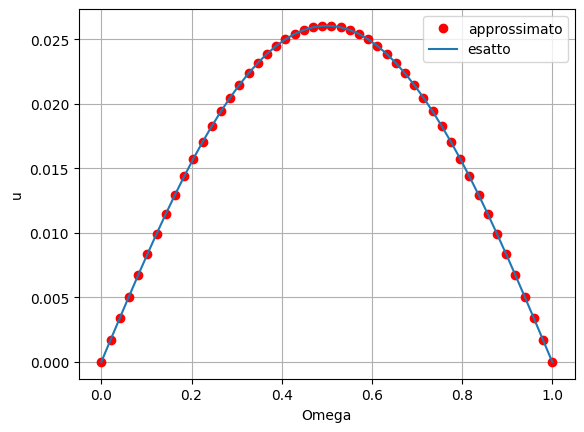

In [ ]:
omega_new = [0, 1]
n_new = 50
x_new = np.linspace(omega_new[0], omega_new[1], n_new)
f_new = lambda x_new : x_new*(1 - x_new)
bc_new = [0, 0]

A_new, b_new = finDif(omega_new, f_new, n_new, bc_new)
A1_new = A_new.copy()
L_new, U_new = LU(A1_new)
w_new = L_solve(L_new, b_new)
u_new = U_solve(U_new, w_new)

# Soluzione esatta
u_ex = (x_new**4)/12.0 - (x_new**3)/6.0 + x_new/12.0

plt.plot(x_new, u_new, 'or', label='approssimato')
plt.plot(x_new, u_ex, label='esatto')
plt.xlabel('Omega')
plt.ylabel('u')
plt.legend()
plt.grid()

print('Errore:', np.linalg.norm(u_ex - u_new, 2))

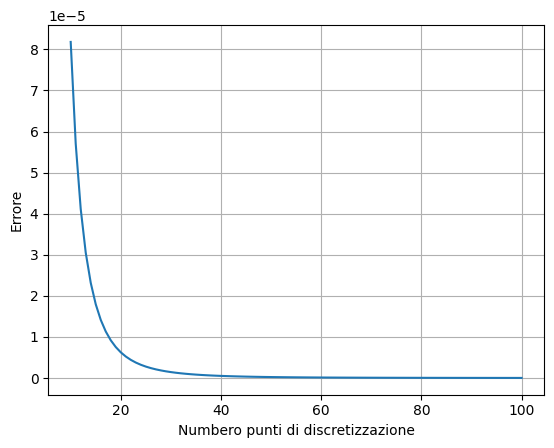

In [ ]:
omega_new = [0, 1]
bc_new = [0, 0]

error = []
n_points = np.array([x for x in range(10, 101)])

for j in n_points:
    x_new = np.linspace(omega_new[0], omega_new[1], j)
    f_new = lambda x_new : x_new*(1 - x_new)
    u_ex = (x_new**4)/12.0 - (x_new**3)/6.0 + x_new/12.0

    A_new, b_new = finDif(omega_new, f_new, j, bc_new)
    A1_new = A_new.copy()
    u_new = np.linalg.solve(A1_new, b_new)

    error.append(np.linalg.norm(u_ex - u_new, 2))

plt.plot(n_points, error)
plt.xlabel('Numbero punti di discretizzazione')
plt.ylabel('Errore')
plt.grid()

Exploit the derived LU factorizations to compute the determinant of the system's matrix $A$ using the original problem formulation.

In [ ]:
# La funizone implementa il calcolo del deterninante della matrice A
def determinant(A):
    L, U = LU(A)
    size = A.shape[0]
    determinant = 1

    for i in range(size):
        determinant *= U[i, i]

    return determinant

print('Determinante(A):', determinant(A))

Determinante(A): 8.194685190047183e+301


In [ ]:
# Numero di condizionamento
def condNum(A):
    return np.linalg.norm(A, 2) * np.linalg.norm(np.linalg.inv(A), 2)

print('Numero di Condizionamento(A):', condNum(A))

Numero di Condizionamento(A): 37738.9737111139


Implement a preconditioned Conjugant Gradient method to solve the original linear system of equations using an iterative method:

## Conjugate gradient
   
   $$
   \alpha^k = \frac{{\bf p}^{k^{T}} {\bf r}^k}{{\bf p}^{k^{T}} A{\bf p}^k}
   $$
   
      
   $$
   {\bf x}^{k+1} = {\bf x}^k + \alpha^k {\bf p}^k
   $$
   
   $$
   {\bf r}^{k+1} = {\bf r}^k - \alpha^kA {\bf p}^k
   $$

   $$
   \beta^k = \frac{(A{\bf p}^{k})^{T}{\bf r}^{k+1}}{(A{\bf p}^{k})^{T}  {\bf p}^k}
   $$
   
   $$
   {\bf p}^{k+1} = {\bf r}^{k+1} - \beta^k{\bf p}^k
   $$

In [ ]:
# La funzione implementa il metodo del gradiente coniugato per risolvere il sistema lineare di equazioni nella forma PAx = b
def conjugate_gradient(A, b, P, nmax, eps=1e-10):

    #criterio di arresto sul num. di iterazioni
    if nmax <= len(A):
        N = nmax
    else:
        N = len(A)

    x = np.zeros_like(b)
    tol = eps + 1
    it = 0
    r = b - np.dot(A,x)
    rho_old = 1.
    p_old = np.zeros_like(b)

    while (it < N and tol > eps):
        it += 1
        z = np.linalg.solve(P,r)
        rho = np.dot(r,z)

        if (it > 1):
            beta = rho/rho_old
            p = z + beta*p_old
        else:
            p = z

        q = np.dot(A,p)
        alpha = rho/(np.dot(p,q))
        x += p*alpha
        r -= q*alpha

        p_old = p
        rho_old = rho

        tol = np.linalg.norm(r, 2)

    print('Iterazioni:\t', it)
    print('Tolleranza:\t', tol)
    return x

In [ ]:
# Parametri
omega2 = [0, np.pi]
f2 = lambda x : np.sin(x)
n2 = 50
bc2 = [0, 0]

# Metodo esatto
A2, b2 = finDif(omega2, f2, n2, bc2)
L2, U2 = LU(A2)
w2 = L_solve(L2, b2)
u2 = U_solve(U2, w2)

# Metodo iterativo
sol_conjugate_gradient = conjugate_gradient(A2, b2, np.identity(len(A2)), n2)
print('Errore:\t\t', np.linalg.norm(sol_conjugate_gradient - u2)/np.linalg.norm(u))

# %time sol_conjugate_gradient = conjugate_gradient(A2, b2, np.identity(len(A2)), n2)

Iterazioni:	 50
Tolleranza:	 1.9029288605195382
Errore:		 0.01515312174461731


Consider the following time dependent variation of the PDE starting from the orginal problem formulation:
$$
u'(t)-u_{xx} = \alpha(t)f(x)
$$

for $t\in [0,T]$, with $\alpha(t) = \cos(t)$ and $T = 6\pi$

Use the same finite difference scheme to derive the semi-discrete formulation and solve it using a forward Euler's method.

Plot the time dependent solution solution at $x = \pi/2$, $x=1$,
$x=\pi$


In [ ]:
# Parametri
T = np.pi*6   #Tempo totale
n = 100  # Num punti dicreti nello spazio
nt = 500  # Num punti discrti nel tempo
dt = T / nt
alpha = lambda t: np.cos(t)

# Griglia dello spazio
x_values = np.linspace(0, np.pi, n)
dx = x_values[1] - x_values[0]

# Griglia temporale
u_values = np.zeros((nt + 1, n))

# Condizioni iniziali
u_values[0, :] = np.sin(x_values)

# Iterazione
for t in range(nt):
    uxx = np.zeros(n)
    for i in range(1, n - 1):
        uxx[i] = (-u_values[t, i + 1] + 16 * u_values[t, i] - 30 * u_values[t, i - 1] + 16 * u_values[t, i - 2] - u_values[t, i - 3]) / (12 * dx**2)

    u_values[t + 1, 1:-1] = u_values[t, 1:-1] + dt * (alpha(t * dt) * uxx[1:-1])

# Plot
# ///


<ipython-input-168-5f66ec533885>:22: RuntimeWarning: overflow encountered in double_scalars
  uxx[i] = (-u_values[t, i + 1] + 16 * u_values[t, i] - 30 * u_values[t, i - 1] + 16 * u_values[t, i - 2] - u_values[t, i - 3]) / (12 * dx**2)
<ipython-input-168-5f66ec533885>:24: RuntimeWarning: invalid value encountered in add
  u_values[t + 1, 1:-1] = u_values[t, 1:-1] + dt * (alpha(t * dt) * uxx[1:-1])


Given the original $Au = b$ system, implement an algorithm to compute the largest and smallest eigenvalues and the associated eigenvectors of the matrix $A$.

# Eigenvalue and eigenvectors calculation

$$
A\mathbf{x} = \lambda \mathbf{x}
$$

### Power method (vector iteration)
- find the largest eigenvalue $\lambda_{max}$
\begin{align}
\mathbf{q}_k & = \frac{\mathbf{z}_{k-1}}{\|\mathbf{z}_{k-1}\|_2}\\
\mathbf{z}_k & = A\mathbf{q}_{k}\\
\lambda_{max}^k & = \mathbf{q}^T_k \mathbf{z}_k
\end{align}

In [ ]:
#La funzione implementa il metodo della potenza per trovare l'autovalore e l'autovettore più grandi della matrice A
z0 = np.ones_like(b)

def PM(A, z0, tol=1e-8, nmax=500):
    z = z0   # valore iniziale dell'autovettore
    it = 0
    eps = tol + 1

    while (it < nmax and eps > tol):
        it += 1
        q = z / (np.linalg.norm(z))
        if (it == 1):
            l_km1 = q.T @ z
        else:
            l_km1 = l.copy()

        z = A @ q
        l = q.T @ z
        eps = np.linalg.norm(A @ q - l * q, 2)

    return l, q

In [ ]:
# Stampo l'autovalore minimo
l, x = PM(A, z0)
print("l_max =", l)

l_max = -446.7457230903773


### Inverse power method
- find the eigenvalue $\lambda$ **closest** to $\mu$
\begin{align}
M & = A-\mu I\\
M & = LU \\
& \\
M\mathbf{x}_k &= \mathbf q_{k-1}\\
\mathbf{q}_k & = \frac{\mathbf{x}_k}{\|\mathbf{x}_k\|_2}\\
\mathbf{z}_k & = A\mathbf{q}_{k}\\
\lambda^k & = \mathbf{q}^T_k \mathbf{z}_k
\end{align}

In [ ]:
# La funzione implementa il metodo della potenza inversa per trovare l'autovalore e l'autovettore più piccoli della matrice A
def IPM(A, x0, mu, tol=1e-10, nmax=500):
    M = A - mu * np.identity(A.shape[0])
    P, L, U = scipy.linalg.lu(M)
    it = 0
    eps = tol + 1
    while (it < nmax and eps > tol):
        it += 1

        if (it == 1):
            q_km1 = x0 / np.linalg.norm(x0)
        else:
            q_km1 = q.copy()
        y = scipy.linalg.solve_triangular(L, P.T@q_km1, lower= True)
        x = scipy.linalg.solve_triangular(U, y, lower=False)
        q = x / np.linalg.norm(x)
        z = A @ q

        if (it == 1):
            l_km1 = q.T @ z
        else:
            l_km1 = l.copy()
        l = q.T @ z
        eps = np.linalg.norm(A @ q - l * q)

    return l, q

In [ ]:
# Stampo l'autovalore minimo
l, x = IPM(A, z0, 0.5)
print("l_min =", l)

l_min = 1.0000000000865545


Compute the inverse of the matrix A exploiting the derived LU factorization

In [ ]:
# Calcolo la matrice inversa di A usando la fattorizzazione LU
def inverseMatrix(A):
    size = round(np.sqrt(A.size))
    E = np.eye(size)
    X = np.zeros_like(E)
    W = np.zeros_like(E)
    L, U = LU(A)

    for i in range(size):
        W[:, i:] = L_solve(L, E[:,i:])
        X[:, i:] = U_solve(U, W[:,i:])

    return X

Consider the following Cauchy problem
$$
\begin{cases}
y'= -ty^2 \quad 0\le t \le 2\\
y(0) = 1
\end{cases}
$$
Implement a Backward Euler's method in a suitable function and solve the resulting non-linear equation using a Newton's method.

# ODE

We will solve the following linear Cauchy model

\begin{align}
y^{\prime}(t) &= \lambda y(t)\\
y(0) & = 1
\end{align}

whose exact solution is

$$
y(t) = e^{\lambda t}
$$

### Backward Euler

$$
\frac{y_{n}-y_{n-1}}{h} = f(y_{n}, t_{n})
$$

### Newton's Method
$$
q^n = g^{\prime}(y_n) = \frac{dg(y_n)}{dy_n} = 2 h t y_n + 1
$$

$$
y_{n+1} = y_n - \frac{g(y_n)}{q^n}
$$

In [ ]:
# La funzione implementa il metodo di Newton per trovare gli zero della funzione f
def newton(f, f_prime, x0, eps=1e-30, n_max=10000):
    x = x0  #guess iniziale
    err = abs(f(x))
    errors = [err]  #lista errori

    err = eps + 1.
    it = 0
    while (err > eps and it < n_max):
        qk = f_prime(x)
        if (abs(qk) < 1e-12):
            raise RuntimeError("f_prime(x) is close to zero")
        x = x - (f(x) / qk)

        # calcolo e salvo l'errore
        err = abs(f(x))
        errors.append(err)
        it += 1

    return x, errors

In [ ]:
# La funzione implementa il Metodo di Eulero all'indietro per risolvere l'ODE
def be(y0, t0, tf, h):
    timesteps = np.arange(t0, tf+1e-10, h)
    sol = np.zeros_like(timesteps)

    sol[0] = y0
    for i in range(1, len(sol)):
        t = timesteps[i-1]
        g = lambda y: h * t * y**2 + y - sol[i-1]
        g_prime = lambda y: 2 * h * t * y + 1
        sol[i], errors = newton(g, g_prime, y0)

    return sol, timesteps

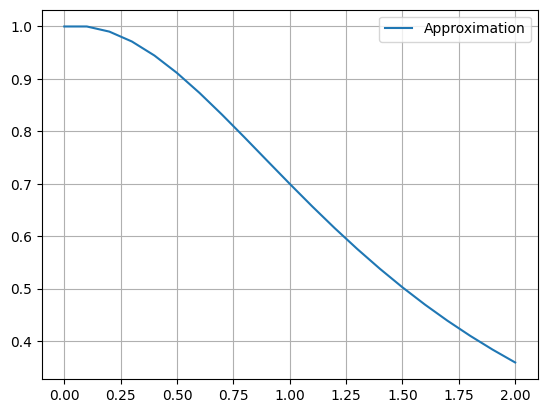

In [ ]:
# Parametri
t0 = 0
tf = 2
y0 = 1
h = 0.1

# Soluzione
y, t = be(y0, t0, tf, h)

plt.plot(t, y, '-', label='Approximation')
plt.legend()
plt.grid()